In [47]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pickle
import seaborn as sns

from scipy.stats import pearsonr

import skimage
from skimage.exposure import histogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples

import sys
sys.path.insert(0,'../')
import NEU_utils

In [3]:
with open('../vgg16_data/fc1_features_std.pickle', 'rb') as f:
    data = pickle.load(f)

In [8]:
files = data['filename']
fc1 = data['fc1']

labels = [x[:2] for x in files]
y_true = [NEU_utils.label_mapper[x] for x in labels]

pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)



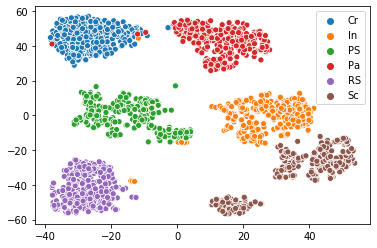

In [9]:
tsne = TSNE(n_components=2, random_state=12213)
x_nw_tsne = tsne.fit_transform(x_nw)
fig, ax = plt.subplots()
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], hue=labels)

In [41]:
accs = []
inertias = []
n_rs = 5000
for rs in range(n_rs):
    kmeans = KMeans(n_clusters=7, init='k-means++', n_init=1, random_state=rs)
    kmeans.fit(x)
    labels_unmatched = kmeans.labels_
    y_pred = NEU_utils.file_matcher(labels_unmatched, labels, NEU_utils.label_mapper)
    CM = confusion_matrix(y_true, y_pred)
    accs.append(CM.trace()/CM.sum())
    inertias.append(kmeans.inertia_)

In [42]:
with open('sensitivity_data/kmeans_n_init.pickle', 'wb') as f:
    pickle.dump({
        'random_states' : list(range(n_rs)),
        'accs' : accs,
        'inertias' : inertias
    },
    f)

(-0.8060705086468957, 0.0)

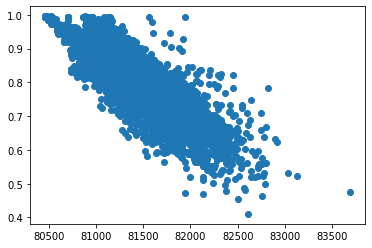

In [48]:
plt.plot(inertias, accs, 'o')
pearsonr(inertias, accs)

In [55]:
np.mean(accs)

0.7976277777777777

(array([  1.,   2.,   7.,  14.,  25.,  41.,  85., 144., 208., 296., 436.,
        472., 548., 606., 576., 508., 335., 311., 217., 168.]),
 array([0.41055556, 0.43980556, 0.46905556, 0.49830556, 0.52755556,
        0.55680556, 0.58605556, 0.61530556, 0.64455556, 0.67380556,
        0.70305556, 0.73230556, 0.76155556, 0.79080556, 0.82005556,
        0.84930556, 0.87855556, 0.90780556, 0.93705556, 0.96630556,
        0.99555556]),
 <a list of 20 Patch objects>)

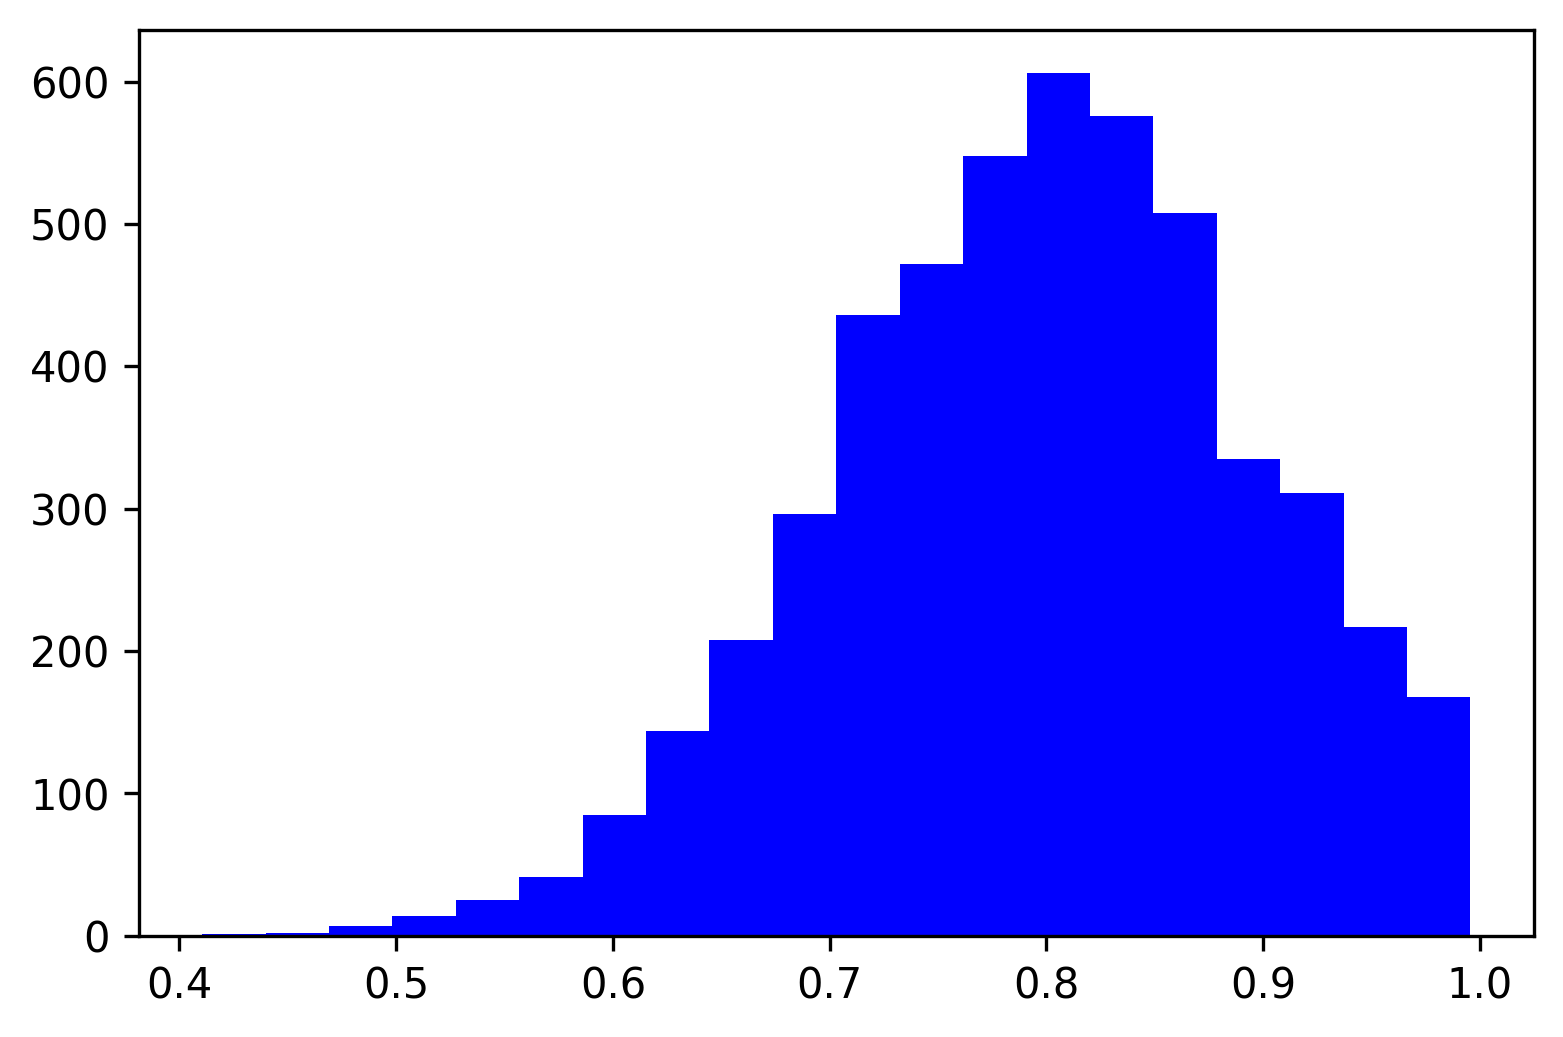

In [62]:
inertias = np.asarray(inertias)
fig, ax = plt.subplots(dpi=300)
#ax.hist(inertias/inertias.max(), bins=20, color='y')
ax.hist(accs, bins=20, color='b')

(array([ 83.,  95., 228., 538., 730., 691., 716., 716., 522., 316., 157.,
        117.,  53.,  20.,  13.,   3.,   1.,   0.,   0.,   1.]),
 array([0.96141831, 0.96334739, 0.96527648, 0.96720556, 0.96913465,
        0.97106373, 0.97299282, 0.9749219 , 0.97685098, 0.97878007,
        0.98070915, 0.98263824, 0.98456732, 0.98649641, 0.98842549,
        0.99035458, 0.99228366, 0.99421275, 0.99614183, 0.99807092,
        1.        ]),
 <a list of 20 Patch objects>)

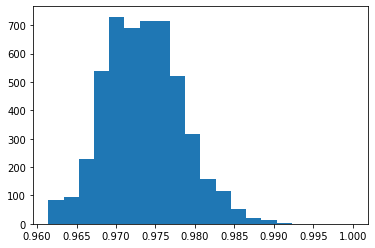

In [57]:
plt.hist(np.asarray(inertias)/np.asarray(inertias).max(), bins=20)

(array([  1.,   2.,   7.,  14.,  25.,  41.,  85., 144., 208., 296., 436.,
        472., 548., 606., 576., 508., 335., 311., 217., 168.]),
 array([0.41055556, 0.43980556, 0.46905556, 0.49830556, 0.52755556,
        0.55680556, 0.58605556, 0.61530556, 0.64455556, 0.67380556,
        0.70305556, 0.73230556, 0.76155556, 0.79080556, 0.82005556,
        0.84930556, 0.87855556, 0.90780556, 0.93705556, 0.96630556,
        0.99555556]),
 <a list of 20 Patch objects>)

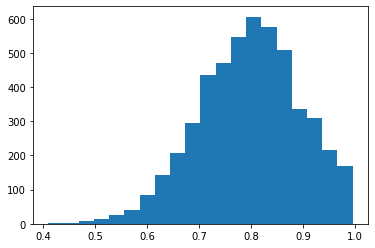

In [52]:
plt.hist(accs, bins=20)

In [35]:
K = np.arange(6,21, dtype=np.int)
silhouettes = []
accs =[]
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=500, 
                random_state=24654)
    kmeans.fit(x)
    labels_unmatched = kmeans.labels_
    y_pred = NEU_utils.file_matcher(labels_unmatched, labels, NEU_utils.label_mapper)
    CM = confusion_matrix(y_true, y_pred)
    silhouette = silhouette_samples(x, y_pred)
    silhouettes.append(silhouette)
    accs.append(CM.trace()/CM.sum())

(array([ 26., 120., 340., 654.,  75., 148., 142.,  67., 156.,  72.]),
 array([-0.302113  , -0.24379496, -0.18547691, -0.12715888, -0.06884084,
        -0.0105228 ,  0.04779524,  0.10611328,  0.16443132,  0.22274937,
         0.2810674 ], dtype=float32),
 <a list of 10 Patch objects>)

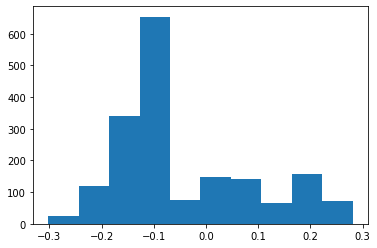

In [37]:
plt.hist(silhouette)

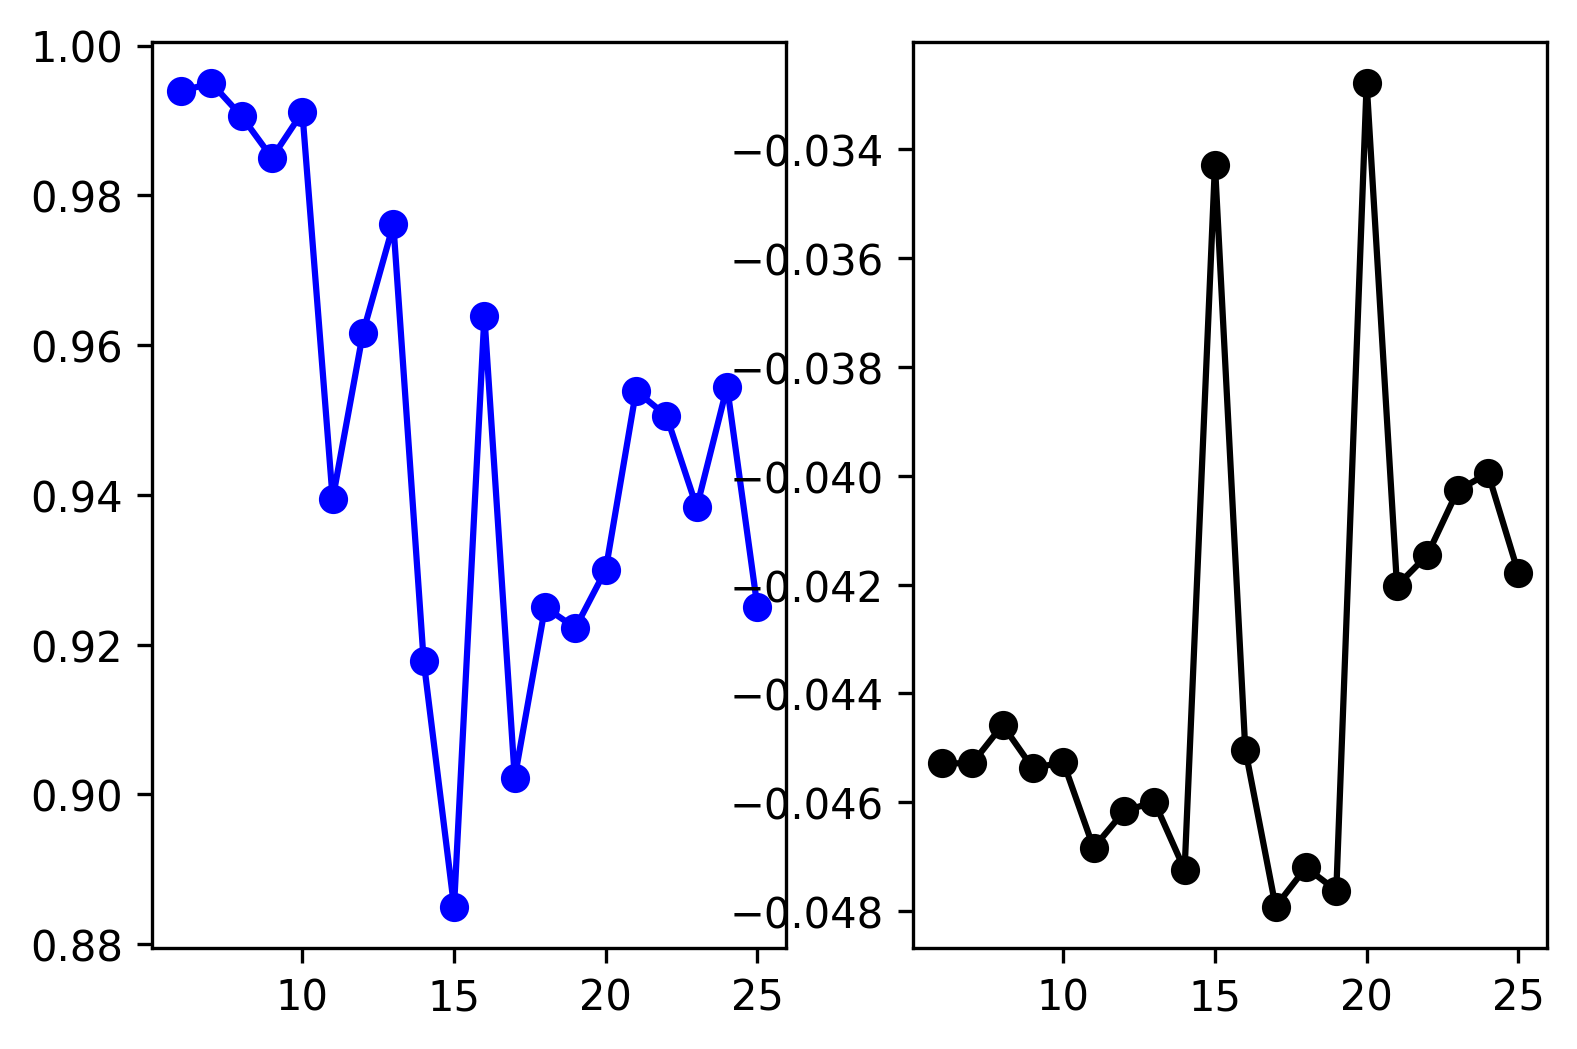

In [32]:
fig, ax = plt.subplots(1,2, dpi=300)
ax[0].plot(K, accs, '-bo')
ax[1].plot(K, [x.mean() for x in silhouettes], '-ko')
#ax[1].plot(K, [np.median(x) for x in silhouettes], ':o')

In [20]:
# points = np.array([
#     [0,1],[1,0],[0,-1],[-1,0],
#     [5,1],[6,0],[5,-1],[4,0]
# ])
# clusters = [1,1,1,1,2,2,2,2]
points = np.array([
    [-1],[1], [4],[5]
])
clusters = [1,1,2,2]

In [21]:
silhouette_samples(points, clusters)

array([0.63636364, 0.42857143, 0.75      , 0.8       ])

In [31]:
[(5.5-2)/(5.5), (3.5-2)/(3.5), (4-1)/(4), (5-1)/(5)]

[0.6363636363636364, 0.42857142857142855, 0.75, 0.8]